In [1]:
using ForwardDiff
using LaTeXStrings
using NLsolve
using Plots
using LinearAlgebra
using PyCall
using JLD
using SparseArrays

#### Le but de ces lignes de code est d'implémenter un schéma aux différences finies pour l'équation d'advection-diffusion en 2D.

On définit les paramètres de la grille de discrétisation en espace : N, num_cells, dx.
On définit également le nombre d'espèces chimiques num_species et le pas de temps dt. 

In [2]:
# N: nombre d'intervalles de discrétisation dans chaque dimension
#const N = 200;
const Nx =256; 
const Nv =256; 

# num_cells: nombre de cellules
const num_cells =  Nx*Nv;

vmin = -10
vmax = 10

const dx = 10*pi/Nx;
const dy = (vmax-vmin)/Nv
const dt = 0.01;

#T1= 0.25
T = 50

const grid1Dx = range(0, 10*pi, length=Nx) |> collect;
const grid1Dv = range(-10, 10, length=Nv) |> collect;

getNumCase est la fonction qui renvoie à un couple d'entiers $i,j$ tels que $1\leq i,j \leq N$ renvoie le numéro de la case $1\leq m \leq N^2$ correspondante. 

In [3]:
#Retourne l'indice de la case m en fonction des indices (i,j) (1 <= i,j <= N) 
function getNumCase(i,j)
   #return (j-1)*Nx+i;
   return (i-1)*Nv+j;
end

getNumCase (generic function with 1 method)

getIndicesCase fait l'opération inverse de la fonction getNumCase ci-dessus. 

In [4]:
#Retourne l'indice de la case m en fonction des indices (i,j) ( 1<= i,j <= N) 
function getIndicesCase(m)
  # i = m - floor(Int, (m-1)/Nx)*Nx
  # j = floor(Int, (m-i)/Nx) +1 
  j= m - floor(Int, (m-1)/Nv)*Nv
  i = floor(Int, (m-j)/Nv) +1 
   return i,j
end

getIndicesCase (generic function with 1 method)

Définition de la condition initiale

In [5]:
U0 = zeros(num_cells);
#v0 = 1.3
#v0 = 2.4
v0 = 3.5
beta = 1e-3

function g(x1,x2)
    return (1+ beta*cos(0.2*x1)) *(1.0/(2*sqrt(2*pi))*exp(-0.5*(x2-v0)^2) +  1.0/(2*sqrt(2*pi))*exp(-0.5*(x2+v0)^2))
end

for i=1:Nx
    for j=1:Nv
        xi = (i-0.5)*dx
        yj = vmin + (j-0.5)*dy
        m = getNumCase(i,j)
        println(m)
        U0[m] = g(xi,yj)
    end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2271
2272
2273
2274
2275
2276
2277
2278
2279
2280
2281
2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294
2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308
2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470


4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518


6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556
6557
6558
6559
6560
6561
6562
6563
6564
6565
6566


9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060

11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
1176

13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464
13465
13466
13467
13468
13469
13470
13471
13472
13473
1347

15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792
15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804
15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816
15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828
15829
15830
15831
15832
15833
15834
15835
1583

17377
17378
17379
17380
17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392
17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405
17406
17407
17408
17409
17410
17411
17412
17413
17414
17415
17416
17417
17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429
17430
17431
17432
17433
17434
17435
17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450
17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461
17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472
17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487
17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498
17499
17500
17501
17502
17503
17504
17505
17506
17507
17508
17509
17510
17511
17512
17513
17514
17515
17516
17517
17518
17519
17520
17521
17522
17523
17524
17525
17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537
17538
17539
17540
17541
17542
1754

19084
19085
19086
19087
19088
19089
19090
19091
19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103
19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117
19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131
19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144
19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155
19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168
19169
19170
19171
19172
19173
19174
19175
19176
19177
19178
19179
19180
19181
19182
19183
19184
19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196
19197
19198
19199
19200
19201
19202
19203
19204
19205
19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218
19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230
19231
19232
19233
19234
19235
19236
19237
19238
19239
19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
1925

20791
20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802
20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
20867
20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881
20882
20883
20884
20885
20886
20887
20888
20889
20890
20891
20892
20893
20894
20895
20896
20897
20898
20899
20900
20901
20902
20903
20904
20905
20906
20907
20908
20909
20910
20911
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928
20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954
20955
20956
2095

23332
23333
23334
23335
23336
23337
23338
23339
23340
23341
23342
23343
23344
23345
23346
23347
23348
23349
23350
23351
23352
23353
23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367
23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381
23382
23383
23384
23385
23386
23387
23388
23389
23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400
23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411
23412
23413
23414
23415
23416
23417
23418
23419
23420
23421
23422
23423
23424
23425
23426
23427
23428
23429
23430
23431
23432
23433
23434
23435
23436
23437
23438
23439
23440
23441
23442
23443
23444
23445
23446
23447
23448
23449
23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460
23461
23462
23463
23464
23465
23466
23467
23468
23469
23470
23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484
23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
2349

25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
2520

26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809
26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824
26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836
26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848
26849
26850
26851
26852
26853
26854
26855
26856
26857
26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869
26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883
26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894
26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905
26906
26907
26908
26909
26910
26911
2691

28453
28454
28455
28456
28457
28458
28459
28460
28461
28462
28463
28464
28465
28466
28467
28468
28469
28470
28471
28472
28473
28474
28475
28476
28477
28478
28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491
28492
28493
28494
28495
28496
28497
28498
28499
28500
28501
28502
28503
28504
28505
28506
28507
28508
28509
28510
28511
28512
28513
28514
28515
28516
28517
28518
28519
28520
28521
28522
28523
28524
28525
28526
28527
28528
28529
28530
28531
28532
28533
28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545
28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556
28557
28558
28559
28560
28561
28562
28563
28564
28565
28566
28567
28568
28569
28570
28571
28572
28573
28574
28575
28576
28577
28578
28579
28580
28581
28582
28583
28584
28585
28586
28587
28588
28589
28590
28591
28592
28593
28594
28595
28596
28597
28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612
28613
28614
28615
28616
28617
28618
2861

31028
31029
31030
31031
31032
31033
31034
31035
31036
31037
31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050
31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064
31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078
31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093
31094
31095
31096
31097
31098
31099
31100
31101
31102
31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113
31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124
31125
31126
31127
31128
31129
31130
31131
31132
31133
31134
31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148
31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31160
31161
31162
31163
31164
31165
31166
31167
31168
31169
31170
31171
31172
31173
31174
31175
31176
31177
31178
31179
31180
31181
31182
31183
31184
31185
31186
31187
31188
31189
31190
31191
31192
31193
3119

32735
32736
32737
32738
32739
32740
32741
32742
32743
32744
32745
32746
32747
32748
32749
32750
32751
32752
32753
32754
32755
32756
32757
32758
32759
32760
32761
32762
32763
32764
32765
32766
32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
32778
32779
32780
32781
32782
32783
32784
32785
32786
32787
32788
32789
32790
32791
32792
32793
32794
32795
32796
32797
32798
32799
32800
32801
32802
32803
32804
32805
32806
32807
32808
32809
32810
32811
32812
32813
32814
32815
32816
32817
32818
32819
32820
32821
32822
32823
32824
32825
32826
32827
32828
32829
32830
32831
32832
32833
32834
32835
32836
32837
32838
32839
32840
32841
32842
32843
32844
32845
32846
32847
32848
32849
32850
32851
32852
32853
32854
32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
32884
32885
32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900
3290

34442
34443
34444
34445
34446
34447
34448
34449
34450
34451
34452
34453
34454
34455
34456
34457
34458
34459
34460
34461
34462
34463
34464
34465
34466
34467
34468
34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481
34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
34601
34602
34603
34604
34605
34606
34607
3460

36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
36227
36228
36229
36230
36231
36232
36233
36234
36235
36236
36237
36238
36239
36240
36241
36242
36243
36244
36245
36246
36247
36248
36249
36250
36251
36252
36253
36254
36255
36256
36257
36258
36259
36260
36261
36262
36263
36264
36265
36266
36267
36268
36269
36270
36271
36272
36273
36274
36275
36276
36277
36278
36279
36280
36281
36282
36283
36284
36285
36286
36287
36288
36289
36290
36291
36292
36293
36294
36295
36296
36297
36298
36299
36300
36301
36302
36303
36304
36305
36306
36307
36308
36309
36310
36311
36312
36313
36314
3631

38068
38069
38070
38071
38072
38073
38074
38075
38076
38077
38078
38079
38080
38081
38082
38083
38084
38085
38086
38087
38088
38089
38090
38091
38092
38093
38094
38095
38096
38097
38098
38099
38100
38101
38102
38103
38104
38105
38106
38107
38108
38109
38110
38111
38112
38113
38114
38115
38116
38117
38118
38119
38120
38121
38122
38123
38124
38125
38126
38127
38128
38129
38130
38131
38132
38133
38134
38135
38136
38137
38138
38139
38140
38141
38142
38143
38144
38145
38146
38147
38148
38149
38150
38151
38152
38153
38154
38155
38156
38157
38158
38159
38160
38161
38162
38163
38164
38165
38166
38167
38168
38169
38170
38171
38172
38173
38174
38175
38176
38177
38178
38179
38180
38181
38182
38183
38184
38185
38186
38187
38188
38189
38190
38191
38192
38193
38194
38195
38196
38197
38198
38199
38200
38201
38202
38203
38204
38205
38206
38207
38208
38209
38210
38211
38212
38213
38214
38215
38216
38217
38218
38219
38220
38221
38222
38223
38224
38225
38226
38227
38228
38229
38230
38231
38232
38233
3823

39775
39776
39777
39778
39779
39780
39781
39782
39783
39784
39785
39786
39787
39788
39789
39790
39791
39792
39793
39794
39795
39796
39797
39798
39799
39800
39801
39802
39803
39804
39805
39806
39807
39808
39809
39810
39811
39812
39813
39814
39815
39816
39817
39818
39819
39820
39821
39822
39823
39824
39825
39826
39827
39828
39829
39830
39831
39832
39833
39834
39835
39836
39837
39838
39839
39840
39841
39842
39843
39844
39845
39846
39847
39848
39849
39850
39851
39852
39853
39854
39855
39856
39857
39858
39859
39860
39861
39862
39863
39864
39865
39866
39867
39868
39869
39870
39871
39872
39873
39874
39875
39876
39877
39878
39879
39880
39881
39882
39883
39884
39885
39886
39887
39888
39889
39890
39891
39892
39893
39894
39895
39896
39897
39898
39899
39900
39901
39902
39903
39904
39905
39906
39907
39908
39909
39910
39911
39912
39913
39914
39915
39916
39917
39918
39919
39920
39921
39922
39923
39924
39925
39926
39927
39928
39929
39930
39931
39932
39933
39934
39935
39936
39937
39938
39939
39940
3994

41482
41483
41484
41485
41486
41487
41488
41489
41490
41491
41492
41493
41494
41495
41496
41497
41498
41499
41500
41501
41502
41503
41504
41505
41506
41507
41508
41509
41510
41511
41512
41513
41514
41515
41516
41517
41518
41519
41520
41521
41522
41523
41524
41525
41526
41527
41528
41529
41530
41531
41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
4164

43189
43190
43191
43192
43193
43194
43195
43196
43197
43198
43199
43200
43201
43202
43203
43204
43205
43206
43207
43208
43209
43210
43211
43212
43213
43214
43215
43216
43217
43218
43219
43220
43221
43222
43223
43224
43225
43226
43227
43228
43229
43230
43231
43232
43233
43234
43235
43236
43237
43238
43239
43240
43241
43242
43243
43244
43245
43246
43247
43248
43249
43250
43251
43252
43253
43254
43255
43256
43257
43258
43259
43260
43261
43262
43263
43264
43265
43266
43267
43268
43269
43270
43271
43272
43273
43274
43275
43276
43277
43278
43279
43280
43281
43282
43283
43284
43285
43286
43287
43288
43289
43290
43291
43292
43293
43294
43295
43296
43297
43298
43299
43300
43301
43302
43303
43304
43305
43306
43307
43308
43309
43310
43311
43312
43313
43314
43315
43316
43317
43318
43319
43320
43321
43322
43323
43324
43325
43326
43327
43328
43329
43330
43331
43332
43333
43334
43335
43336
43337
43338
43339
43340
43341
43342
43343
43344
43345
43346
43347
43348
43349
43350
43351
43352
43353
43354
4335

45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
45804
45805
45806
45807
45808
45809
45810
45811
45812
45813
45814
45815
45816
45817
45818
45819
45820
45821
45822
45823
45824
45825
45826
45827
45828
45829
45830
45831
45832
45833
45834
45835
45836
45837
45838
45839
45840
45841
45842
45843
45844
45845
45846
45847
45848
45849
45850
45851
45852
45853
45854
45855
45856
45857
45858
45859
45860
45861
45862
45863
45864
45865
45866
45867
45868
45869
45870
45871
45872
45873
45874
45875
45876
45877
45878
45879
45880
45881
45882
45883
45884
45885
45886
45887
45888
45889
45890
45891
45892
45893
45894
45895
45896
45897
45898
45899
45900
45901
45902
45903
45904
45905
4590

47447
47448
47449
47450
47451
47452
47453
47454
47455
47456
47457
47458
47459
47460
47461
47462
47463
47464
47465
47466
47467
47468
47469
47470
47471
47472
47473
47474
47475
47476
47477
47478
47479
47480
47481
47482
47483
47484
47485
47486
47487
47488
47489
47490
47491
47492
47493
47494
47495
47496
47497
47498
47499
47500
47501
47502
47503
47504
47505
47506
47507
47508
47509
47510
47511
47512
47513
47514
47515
47516
47517
47518
47519
47520
47521
47522
47523
47524
47525
47526
47527
47528
47529
47530
47531
47532
47533
47534
47535
47536
47537
47538
47539
47540
47541
47542
47543
47544
47545
47546
47547
47548
47549
47550
47551
47552
47553
47554
47555
47556
47557
47558
47559
47560
47561
47562
47563
47564
47565
47566
47567
47568
47569
47570
47571
47572
47573
47574
47575
47576
47577
47578
47579
47580
47581
47582
47583
47584
47585
47586
47587
47588
47589
47590
47591
47592
47593
47594
47595
47596
47597
47598
47599
47600
47601
47602
47603
47604
47605
47606
47607
47608
47609
47610
47611
47612
4761

49154
49155
49156
49157
49158
49159
49160
49161
49162
49163
49164
49165
49166
49167
49168
49169
49170
49171
49172
49173
49174
49175
49176
49177
49178
49179
49180
49181
49182
49183
49184
49185
49186
49187
49188
49189
49190
49191
49192
49193
49194
49195
49196
49197
49198
49199
49200
49201
49202
49203
49204
49205
49206
49207
49208
49209
49210
49211
49212
49213
49214
49215
49216
49217
49218
49219
49220
49221
49222
49223
49224
49225
49226
49227
49228
49229
49230
49231
49232
49233
49234
49235
49236
49237
49238
49239
49240
49241
49242
49243
49244
49245
49246
49247
49248
49249
49250
49251
49252
49253
49254
49255
49256
49257
49258
49259
49260
49261
49262
49263
49264
49265
49266
49267
49268
49269
49270
49271
49272
49273
49274
49275
49276
49277
49278
49279
49280
49281
49282
49283
49284
49285
49286
49287
49288
49289
49290
49291
49292
49293
49294
49295
49296
49297
49298
49299
49300
49301
49302
49303
49304
49305
49306
49307
49308
49309
49310
49311
49312
49313
49314
49315
49316
49317
49318
49319
4932

50861
50862
50863
50864
50865
50866
50867
50868
50869
50870
50871
50872
50873
50874
50875
50876
50877
50878
50879
50880
50881
50882
50883
50884
50885
50886
50887
50888
50889
50890
50891
50892
50893
50894
50895
50896
50897
50898
50899
50900
50901
50902
50903
50904
50905
50906
50907
50908
50909
50910
50911
50912
50913
50914
50915
50916
50917
50918
50919
50920
50921
50922
50923
50924
50925
50926
50927
50928
50929
50930
50931
50932
50933
50934
50935
50936
50937
50938
50939
50940
50941
50942
50943
50944
50945
50946
50947
50948
50949
50950
50951
50952
50953
50954
50955
50956
50957
50958
50959
50960
50961
50962
50963
50964
50965
50966
50967
50968
50969
50970
50971
50972
50973
50974
50975
50976
50977
50978
50979
50980
50981
50982
50983
50984
50985
50986
50987
50988
50989
50990
50991
50992
50993
50994
50995
50996
50997
50998
50999
51000
51001
51002
51003
51004
51005
51006
51007
51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
51020
51021
51022
51023
51024
51025
51026
5102

53433
53434
53435
53436
53437
53438
53439
53440
53441
53442
53443
53444
53445
53446
53447
53448
53449
53450
53451
53452
53453
53454
53455
53456
53457
53458
53459
53460
53461
53462
53463
53464
53465
53466
53467
53468
53469
53470
53471
53472
53473
53474
53475
53476
53477
53478
53479
53480
53481
53482
53483
53484
53485
53486
53487
53488
53489
53490
53491
53492
53493
53494
53495
53496
53497
53498
53499
53500
53501
53502
53503
53504
53505
53506
53507
53508
53509
53510
53511
53512
53513
53514
53515
53516
53517
53518
53519
53520
53521
53522
53523
53524
53525
53526
53527
53528
53529
53530
53531
53532
53533
53534
53535
53536
53537
53538
53539
53540
53541
53542
53543
53544
53545
53546
53547
53548
53549
53550
53551
53552
53553
53554
53555
53556
53557
53558
53559
53560
53561
53562
53563
53564
53565
53566
53567
53568
53569
53570
53571
53572
53573
53574
53575
53576
53577
53578
53579
53580
53581
53582
53583
53584
53585
53586
53587
53588
53589
53590
53591
53592
53593
53594
53595
53596
53597
53598
5359

55140
55141
55142
55143
55144
55145
55146
55147
55148
55149
55150
55151
55152
55153
55154
55155
55156
55157
55158
55159
55160
55161
55162
55163
55164
55165
55166
55167
55168
55169
55170
55171
55172
55173
55174
55175
55176
55177
55178
55179
55180
55181
55182
55183
55184
55185
55186
55187
55188
55189
55190
55191
55192
55193
55194
55195
55196
55197
55198
55199
55200
55201
55202
55203
55204
55205
55206
55207
55208
55209
55210
55211
55212
55213
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
55238
55239
55240
55241
55242
55243
55244
55245
55246
55247
55248
55249
55250
55251
55252
55253
55254
55255
55256
55257
55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
5530

56847
56848
56849
56850
56851
56852
56853
56854
56855
56856
56857
56858
56859
56860
56861
56862
56863
56864
56865
56866
56867
56868
56869
56870
56871
56872
56873
56874
56875
56876
56877
56878
56879
56880
56881
56882
56883
56884
56885
56886
56887
56888
56889
56890
56891
56892
56893
56894
56895
56896
56897
56898
56899
56900
56901
56902
56903
56904
56905
56906
56907
56908
56909
56910
56911
56912
56913
56914
56915
56916
56917
56918
56919
56920
56921
56922
56923
56924
56925
56926
56927
56928
56929
56930
56931
56932
56933
56934
56935
56936
56937
56938
56939
56940
56941
56942
56943
56944
56945
56946
56947
56948
56949
56950
56951
56952
56953
56954
56955
56956
56957
56958
56959
56960
56961
56962
56963
56964
56965
56966
56967
56968
56969
56970
56971
56972
56973
56974
56975
56976
56977
56978
56979
56980
56981
56982
56983
56984
56985
56986
56987
56988
56989
56990
56991
56992
56993
56994
56995
56996
56997
56998
56999
57000
57001
57002
57003
57004
57005
57006
57007
57008
57009
57010
57011
57012
5701

59542
59543
59544
59545
59546
59547
59548
59549
59550
59551
59552
59553
59554
59555
59556
59557
59558
59559
59560
59561
59562
59563
59564
59565
59566
59567
59568
59569
59570
59571
59572
59573
59574
59575
59576
59577
59578
59579
59580
59581
59582
59583
59584
59585
59586
59587
59588
59589
59590
59591
59592
59593
59594
59595
59596
59597
59598
59599
59600
59601
59602
59603
59604
59605
59606
59607
59608
59609
59610
59611
59612
59613
59614
59615
59616
59617
59618
59619
59620
59621
59622
59623
59624
59625
59626
59627
59628
59629
59630
59631
59632
59633
59634
59635
59636
59637
59638
59639
59640
59641
59642
59643
59644
59645
59646
59647
59648
59649
59650
59651
59652
59653
59654
59655
59656
59657
59658
59659
59660
59661
59662
59663
59664
59665
59666
59667
59668
59669
59670
59671
59672
59673
59674
59675
59676
59677
59678
59679
59680
59681
59682
59683
59684
59685
59686
59687
59688
59689
59690
59691
59692
59693
59694
59695
59696
59697
59698
59699
59700
59701
59702
59703
59704
59705
59706
59707
5970

61249
61250
61251
61252
61253
61254
61255
61256
61257
61258
61259
61260
61261
61262
61263
61264
61265
61266
61267
61268
61269
61270
61271
61272
61273
61274
61275
61276
61277
61278
61279
61280
61281
61282
61283
61284
61285
61286
61287
61288
61289
61290
61291
61292
61293
61294
61295
61296
61297
61298
61299
61300
61301
61302
61303
61304
61305
61306
61307
61308
61309
61310
61311
61312
61313
61314
61315
61316
61317
61318
61319
61320
61321
61322
61323
61324
61325
61326
61327
61328
61329
61330
61331
61332
61333
61334
61335
61336
61337
61338
61339
61340
61341
61342
61343
61344
61345
61346
61347
61348
61349
61350
61351
61352
61353
61354
61355
61356
61357
61358
61359
61360
61361
61362
61363
61364
61365
61366
61367
61368
61369
61370
61371
61372
61373
61374
61375
61376
61377
61378
61379
61380
61381
61382
61383
61384
61385
61386
61387
61388
61389
61390
61391
61392
61393
61394
61395
61396
61397
61398
61399
61400
61401
61402
61403
61404
61405
61406
61407
61408
61409
61410
61411
61412
61413
61414
6141

64135
64136
64137
64138
64139
64140
64141
64142
64143
64144
64145
64146
64147
64148
64149
64150
64151
64152
64153
64154
64155
64156
64157
64158
64159
64160
64161
64162
64163
64164
64165
64166
64167
64168
64169
64170
64171
64172
64173
64174
64175
64176
64177
64178
64179
64180
64181
64182
64183
64184
64185
64186
64187
64188
64189
64190
64191
64192
64193
64194
64195
64196
64197
64198
64199
64200
64201
64202
64203
64204
64205
64206
64207
64208
64209
64210
64211
64212
64213
64214
64215
64216
64217
64218
64219
64220
64221
64222
64223
64224
64225
64226
64227
64228
64229
64230
64231
64232
64233
64234
64235
64236
64237
64238
64239
64240
64241
64242
64243
64244
64245
64246
64247
64248
64249
64250
64251
64252
64253
64254
64255
64256
64257
64258
64259
64260
64261
64262
64263
64264
64265
64266
64267
64268
64269
64270
64271
64272
64273
64274
64275
64276
64277
64278
64279
64280
64281
64282
64283
64284
64285
64286
64287
64288
64289
64290
64291
64292
64293
64294
64295
64296
64297
64298
64299
64300
6430

In [6]:
U0 = U0/(sum(U0))*Nx*Nv
1.0/Nx*1.0/Nv*sum(U0)

1.0

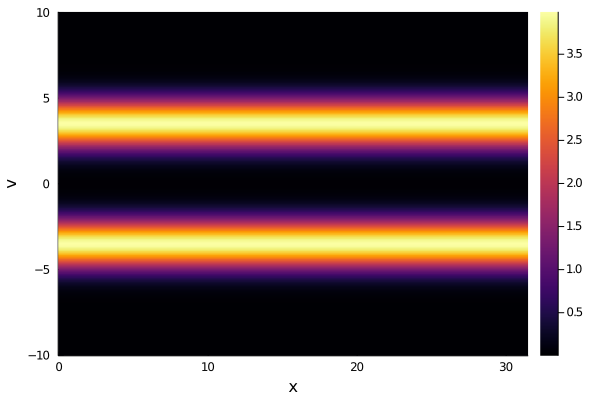

In [7]:
U0tab = reshape(U0, Nv, Nx)
heatmap(grid1Dx, grid1Dv, U0tab, xlabel = "x", ylabel = "v")

Définition de la fonction $b$

In [9]:
V = spzeros(num_cells)
for i=1:Nx
    for j=1:Nv
        xi = (i-0.5)*dx
        vj = vmin + (j-0.5)*dy
        m = getNumCase(i,j)
        V[m] = vj
    end
end

Définition de la matrice du Laplacien en 1D 

In [10]:
Lap = spzeros(Nx,Nx)
for i=1:Nx
        Lap[i,i] = -2.0/(dx*dx)
       
        if (i<Nx)
            mpx = i+1
        else
            mpx =  1
        end
        Lap[i,mpx] = 1.0/(dx*dx)
       
        if (i>1)     
            mmx = i-1
        else
            mmx =  Nx
        end
        Lap[i,mmx] = 1.0/(dx*dx)
end  

Lapnew = Lap[1:(Nx-1), 1:(Nx-1)]

G = spzeros(Nx,Nx)
for i=1:Nx
        G[i,i] = 0
       
        if (i<Nx)
            mpx = i+1
        else
            mpx =  1
        end
        G[i,mpx] = 1.0/(2*dx)
       
        if (i>1)     
            mmx = i-1
        else
            mmx =  Nx
        end
        G[i,mmx] = -1.0/(2*dx)
end  


Définition de la matrice $b\cdot \nabla$ 

In [11]:
VGradx = spzeros(num_cells, num_cells)
for i=1:Nx
    for j=1:Nv
        xi= (i-0.5)*dx
        vj= -vmin + (j-0.5)*dy
        m = getNumCase(i,j)
        VGradx[m,m] = 0
       
        if (i<Nx)
            mpx = getNumCase(i+1,j)
        else
            mpx =  getNumCase(1,j)
        end
        VGradx[m,mpx] = 1.0/(2*dx)*vj
       
        if (i>1)     
            mmx = getNumCase(i-1,j)
        else
            mmx =  getNumCase(Nx,j)
        end
        VGradx[m,mmx] = -1.0/(2*dx)*vj
    end
end  

Compute E

In [12]:
function E(rho)
    rhonew = 1.0 .-rho
    
    rhonew2 = rhonew[1:(Nx-1)]
    Vnew = Lapnew\rhonew2
    
    V = [Vnew;0]
    return G*V
end

print(size(E(U0)))

(256,)

In [13]:
function EGradv(E)
    EGradv = spzeros(num_cells, num_cells)
    for i=1:Nx
        for j=1:Nv
            xi= (i-0.5)*dx
            vj= -5 + (j-0.5)*dy
            m = getNumCase(i,j)
            EGradv[m,m] = 0
       
            if (j<Nv)   
                mpy = getNumCase(i,j+1)
            else
                mpy =  getNumCase(i,1)
            end
            EGradv[m,mpy] = 1.0/(2*dy)*E[i]
        
   
            if (j>1)
                mmy = getNumCase(i,j-1)
            else
                mmy =  getNumCase(i,Nv)
            end
            EGradv[m,mmy] = -1.0/(2*dy)*E[i]
    
        end
    end  
    return EGradv
end

EGradv (generic function with 1 method)

In [14]:
EGradv(E(U0))

65536×65536 SparseMatrixCSC{Float64,Int64} with 131072 stored entries:
  [2    ,     1]  =  -0.49283
  [256  ,     1]  =  0.49283
  [1    ,     2]  =  0.49283
  [3    ,     2]  =  -0.49283
  [2    ,     3]  =  0.49283
  [4    ,     3]  =  -0.49283
  [3    ,     4]  =  0.49283
  [5    ,     4]  =  -0.49283
  [4    ,     5]  =  0.49283
  [6    ,     5]  =  -0.49283
  [5    ,     6]  =  0.49283
  [7    ,     6]  =  -0.49283
  ⋮
  [65531, 65530]  =  0.393092
  [65530, 65531]  =  -0.393092
  [65532, 65531]  =  0.393092
  [65531, 65532]  =  -0.393092
  [65533, 65532]  =  0.393092
  [65532, 65533]  =  -0.393092
  [65534, 65533]  =  0.393092
  [65533, 65534]  =  -0.393092
  [65535, 65534]  =  0.393092
  [65534, 65535]  =  -0.393092
  [65536, 65535]  =  0.393092
  [65281, 65536]  =  0.393092
  [65535, 65536]  =  -0.393092

Le but des lignes de code ci-dessous est de définir la matrice Identité

In [15]:
Id = sparse(I,num_cells, num_cells);

Schéma numérique: schéma explicite centré

In [16]:
n=1

Utab = [U0 U0]
println(size(Utab))
Uold0 = U0

while (n*dt < T)
    print("n = ")
    println(n)
    t = n*dt
    
    Uold0tab = reshape(Uold0, Nv,Nx)
    rho = Uold0tab'*((1.0/Nv)*ones(Nv,1))
    
    #Kmat = VGradx + EGradv(E(rho))
    Kmat = VGradx - EGradv(E(rho))
    #Explicite: 
    #Unew = Uold0 + dt*Kmat*Uold0
    
    #Implicite:
    #Cmat = Id -dt*Kmat
    Cmat = Id  + dt*Kmat;
    Unew = Cmat\Uold0;
    Unew = Unew/sum(Unew)*Nx*Nv;
    print(size(Unew))
    Utab = [Utab Unew]
    Uold0 = Unew
    n = n+1
end

(65536, 2)
n = 1
(65536,)n = 2
(65536,)n = 3
(65536,)n = 4
(65536,)n = 5
(65536,)n = 6
(65536,)n = 7
(65536,)n = 8
(65536,)n = 9
(65536,)n = 10
(65536,)n = 11
(65536,)n = 12
(65536,)n = 13
(65536,)n = 14
(65536,)n = 15
(65536,)n = 16
(65536,)n = 17
(65536,)n = 18
(65536,)n = 19
(65536,)n = 20
(65536,)n = 21
(65536,)n = 22
(65536,)n = 23
(65536,)n = 24
(65536,)n = 25
(65536,)n = 26
(65536,)n = 27
(65536,)n = 28
(65536,)n = 29
(65536,)n = 30
(65536,)n = 31
(65536,)n = 32
(65536,)n = 33
(65536,)n = 34
(65536,)n = 35
(65536,)n = 36
(65536,)n = 37
(65536,)n = 38
(65536,)n = 39
(65536,)n = 40
(65536,)n = 41
(65536,)n = 42
(65536,)n = 43
(65536,)n = 44
(65536,)n = 45
(65536,)n = 46
(65536,)n = 47
(65536,)n = 48
(65536,)n = 49
(65536,)n = 50
(65536,)n = 51
(65536,)n = 52
(65536,)n = 53
(65536,)n = 54
(65536,)n = 55
(65536,)n = 56
(65536,)n = 57
(65536,)n = 58
(65536,)n = 59
(65536,)n = 60
(65536,)n = 61
(65536,)n = 62
(65536,)n = 63
(65536,)n = 64
(65536,)n = 65
(65536,)n = 66
(65536,)n = 67
(

(65536,)n = 519
(65536,)n = 520
(65536,)n = 521
(65536,)n = 522
(65536,)n = 523
(65536,)n = 524
(65536,)n = 525
(65536,)n = 526
(65536,)n = 527
(65536,)n = 528
(65536,)n = 529
(65536,)n = 530
(65536,)n = 531
(65536,)n = 532
(65536,)n = 533
(65536,)n = 534
(65536,)n = 535
(65536,)n = 536
(65536,)n = 537
(65536,)n = 538
(65536,)n = 539
(65536,)n = 540
(65536,)n = 541
(65536,)n = 542
(65536,)n = 543
(65536,)n = 544
(65536,)n = 545
(65536,)n = 546
(65536,)n = 547
(65536,)n = 548
(65536,)n = 549
(65536,)n = 550
(65536,)n = 551
(65536,)n = 552
(65536,)n = 553
(65536,)n = 554
(65536,)n = 555
(65536,)n = 556
(65536,)n = 557
(65536,)n = 558
(65536,)n = 559
(65536,)n = 560
(65536,)n = 561
(65536,)n = 562
(65536,)n = 563
(65536,)n = 564
(65536,)n = 565
(65536,)n = 566
(65536,)n = 567
(65536,)n = 568
(65536,)n = 569
(65536,)n = 570
(65536,)n = 571
(65536,)n = 572
(65536,)n = 573
(65536,)n = 574
(65536,)n = 575
(65536,)n = 576
(65536,)n = 577
(65536,)n = 578
(65536,)n = 579
(65536,)n = 580
(65536,)

(65536,)n = 1029
(65536,)n = 1030
(65536,)n = 1031
(65536,)n = 1032
(65536,)n = 1033
(65536,)n = 1034
(65536,)n = 1035
(65536,)n = 1036
(65536,)n = 1037
(65536,)n = 1038
(65536,)n = 1039
(65536,)n = 1040
(65536,)n = 1041
(65536,)n = 1042
(65536,)n = 1043
(65536,)n = 1044
(65536,)n = 1045
(65536,)n = 1046
(65536,)n = 1047
(65536,)n = 1048
(65536,)n = 1049
(65536,)n = 1050
(65536,)n = 1051
(65536,)n = 1052
(65536,)n = 1053
(65536,)n = 1054
(65536,)n = 1055
(65536,)n = 1056
(65536,)n = 1057
(65536,)n = 1058
(65536,)n = 1059
(65536,)n = 1060
(65536,)n = 1061
(65536,)n = 1062
(65536,)n = 1063
(65536,)n = 1064
(65536,)n = 1065
(65536,)n = 1066
(65536,)n = 1067
(65536,)n = 1068
(65536,)n = 1069
(65536,)n = 1070
(65536,)n = 1071
(65536,)n = 1072
(65536,)n = 1073
(65536,)n = 1074
(65536,)n = 1075
(65536,)n = 1076
(65536,)n = 1077
(65536,)n = 1078
(65536,)n = 1079
(65536,)n = 1080
(65536,)n = 1081
(65536,)n = 1082
(65536,)n = 1083
(65536,)n = 1084
(65536,)n = 1085
(65536,)n = 1086
(65536,)n = 10

(65536,)n = 1511
(65536,)n = 1512
(65536,)n = 1513
(65536,)n = 1514
(65536,)n = 1515
(65536,)n = 1516
(65536,)n = 1517
(65536,)n = 1518
(65536,)n = 1519
(65536,)n = 1520
(65536,)n = 1521
(65536,)n = 1522
(65536,)n = 1523
(65536,)n = 1524
(65536,)n = 1525
(65536,)n = 1526
(65536,)n = 1527
(65536,)n = 1528
(65536,)n = 1529
(65536,)n = 1530
(65536,)n = 1531
(65536,)n = 1532
(65536,)n = 1533
(65536,)n = 1534
(65536,)n = 1535
(65536,)n = 1536
(65536,)n = 1537
(65536,)n = 1538
(65536,)n = 1539
(65536,)n = 1540
(65536,)n = 1541
(65536,)n = 1542
(65536,)n = 1543
(65536,)n = 1544
(65536,)n = 1545
(65536,)n = 1546
(65536,)n = 1547
(65536,)n = 1548
(65536,)n = 1549
(65536,)n = 1550
(65536,)n = 1551
(65536,)n = 1552
(65536,)n = 1553
(65536,)n = 1554
(65536,)n = 1555
(65536,)n = 1556
(65536,)n = 1557
(65536,)n = 1558
(65536,)n = 1559
(65536,)n = 1560
(65536,)n = 1561
(65536,)n = 1562
(65536,)n = 1563
(65536,)n = 1564
(65536,)n = 1565
(65536,)n = 1566
(65536,)n = 1567
(65536,)n = 1568
(65536,)n = 15

(65536,)n = 1993
(65536,)n = 1994
(65536,)n = 1995
(65536,)n = 1996
(65536,)n = 1997
(65536,)n = 1998
(65536,)n = 1999
(65536,)n = 2000
(65536,)n = 2001
(65536,)n = 2002
(65536,)n = 2003
(65536,)n = 2004
(65536,)n = 2005
(65536,)n = 2006
(65536,)n = 2007
(65536,)n = 2008
(65536,)n = 2009
(65536,)n = 2010
(65536,)n = 2011
(65536,)n = 2012
(65536,)n = 2013
(65536,)n = 2014
(65536,)n = 2015
(65536,)n = 2016
(65536,)n = 2017
(65536,)n = 2018
(65536,)n = 2019
(65536,)n = 2020
(65536,)n = 2021
(65536,)n = 2022
(65536,)n = 2023
(65536,)n = 2024
(65536,)n = 2025
(65536,)n = 2026
(65536,)n = 2027
(65536,)n = 2028
(65536,)n = 2029
(65536,)n = 2030
(65536,)n = 2031
(65536,)n = 2032
(65536,)n = 2033
(65536,)n = 2034
(65536,)n = 2035
(65536,)n = 2036
(65536,)n = 2037
(65536,)n = 2038
(65536,)n = 2039
(65536,)n = 2040
(65536,)n = 2041
(65536,)n = 2042
(65536,)n = 2043
(65536,)n = 2044
(65536,)n = 2045
(65536,)n = 2046
(65536,)n = 2047
(65536,)n = 2048
(65536,)n = 2049
(65536,)n = 2050
(65536,)n = 20

(65536,)n = 2475
(65536,)n = 2476
(65536,)n = 2477
(65536,)n = 2478
(65536,)n = 2479
(65536,)n = 2480
(65536,)n = 2481
(65536,)n = 2482
(65536,)n = 2483
(65536,)n = 2484
(65536,)n = 2485
(65536,)n = 2486
(65536,)n = 2487
(65536,)n = 2488
(65536,)n = 2489
(65536,)n = 2490
(65536,)n = 2491
(65536,)n = 2492
(65536,)n = 2493
(65536,)n = 2494
(65536,)n = 2495
(65536,)n = 2496
(65536,)n = 2497
(65536,)n = 2498
(65536,)n = 2499
(65536,)n = 2500
(65536,)n = 2501
(65536,)n = 2502
(65536,)n = 2503
(65536,)n = 2504
(65536,)n = 2505
(65536,)n = 2506
(65536,)n = 2507
(65536,)n = 2508
(65536,)n = 2509
(65536,)n = 2510
(65536,)n = 2511
(65536,)n = 2512
(65536,)n = 2513
(65536,)n = 2514
(65536,)n = 2515
(65536,)n = 2516
(65536,)n = 2517
(65536,)n = 2518
(65536,)n = 2519
(65536,)n = 2520
(65536,)n = 2521
(65536,)n = 2522
(65536,)n = 2523
(65536,)n = 2524
(65536,)n = 2525
(65536,)n = 2526
(65536,)n = 2527
(65536,)n = 2528
(65536,)n = 2529
(65536,)n = 2530
(65536,)n = 2531
(65536,)n = 2532
(65536,)n = 25

(65536,)n = 2957
(65536,)n = 2958
(65536,)n = 2959
(65536,)n = 2960
(65536,)n = 2961
(65536,)n = 2962
(65536,)n = 2963
(65536,)n = 2964
(65536,)n = 2965
(65536,)n = 2966
(65536,)n = 2967
(65536,)n = 2968
(65536,)n = 2969
(65536,)n = 2970
(65536,)n = 2971
(65536,)n = 2972
(65536,)n = 2973
(65536,)n = 2974
(65536,)n = 2975
(65536,)n = 2976
(65536,)n = 2977
(65536,)n = 2978
(65536,)n = 2979
(65536,)n = 2980
(65536,)n = 2981
(65536,)n = 2982
(65536,)n = 2983
(65536,)n = 2984
(65536,)n = 2985
(65536,)n = 2986
(65536,)n = 2987
(65536,)n = 2988
(65536,)n = 2989
(65536,)n = 2990
(65536,)n = 2991
(65536,)n = 2992
(65536,)n = 2993
(65536,)n = 2994
(65536,)n = 2995
(65536,)n = 2996
(65536,)n = 2997
(65536,)n = 2998
(65536,)n = 2999
(65536,)n = 3000
(65536,)n = 3001
(65536,)n = 3002
(65536,)n = 3003
(65536,)n = 3004
(65536,)n = 3005
(65536,)n = 3006
(65536,)n = 3007
(65536,)n = 3008
(65536,)n = 3009
(65536,)n = 3010
(65536,)n = 3011
(65536,)n = 3012
(65536,)n = 3013
(65536,)n = 3014
(65536,)n = 30

(65536,)n = 3439
(65536,)n = 3440
(65536,)n = 3441
(65536,)n = 3442
(65536,)n = 3443
(65536,)n = 3444
(65536,)n = 3445
(65536,)n = 3446
(65536,)n = 3447
(65536,)n = 3448
(65536,)n = 3449
(65536,)n = 3450
(65536,)n = 3451
(65536,)n = 3452
(65536,)n = 3453
(65536,)n = 3454
(65536,)n = 3455
(65536,)n = 3456
(65536,)n = 3457
(65536,)n = 3458
(65536,)n = 3459
(65536,)n = 3460
(65536,)n = 3461
(65536,)n = 3462
(65536,)n = 3463
(65536,)n = 3464
(65536,)n = 3465
(65536,)n = 3466
(65536,)n = 3467
(65536,)n = 3468
(65536,)n = 3469
(65536,)n = 3470
(65536,)n = 3471
(65536,)n = 3472
(65536,)n = 3473
(65536,)n = 3474
(65536,)n = 3475
(65536,)n = 3476
(65536,)n = 3477
(65536,)n = 3478
(65536,)n = 3479
(65536,)n = 3480
(65536,)n = 3481
(65536,)n = 3482
(65536,)n = 3483
(65536,)n = 3484
(65536,)n = 3485
(65536,)n = 3486
(65536,)n = 3487
(65536,)n = 3488
(65536,)n = 3489
(65536,)n = 3490
(65536,)n = 3491
(65536,)n = 3492
(65536,)n = 3493
(65536,)n = 3494
(65536,)n = 3495
(65536,)n = 3496
(65536,)n = 34

(65536,)n = 3921
(65536,)n = 3922
(65536,)n = 3923
(65536,)n = 3924
(65536,)n = 3925
(65536,)n = 3926
(65536,)n = 3927
(65536,)n = 3928
(65536,)n = 3929
(65536,)n = 3930
(65536,)n = 3931
(65536,)n = 3932
(65536,)n = 3933
(65536,)n = 3934
(65536,)n = 3935
(65536,)n = 3936
(65536,)n = 3937
(65536,)n = 3938
(65536,)n = 3939
(65536,)n = 3940
(65536,)n = 3941
(65536,)n = 3942
(65536,)n = 3943
(65536,)n = 3944
(65536,)n = 3945
(65536,)n = 3946
(65536,)n = 3947
(65536,)n = 3948
(65536,)n = 3949
(65536,)n = 3950
(65536,)n = 3951
(65536,)n = 3952
(65536,)n = 3953
(65536,)n = 3954
(65536,)n = 3955
(65536,)n = 3956
(65536,)n = 3957
(65536,)n = 3958
(65536,)n = 3959
(65536,)n = 3960
(65536,)n = 3961
(65536,)n = 3962
(65536,)n = 3963
(65536,)n = 3964
(65536,)n = 3965
(65536,)n = 3966
(65536,)n = 3967
(65536,)n = 3968
(65536,)n = 3969
(65536,)n = 3970
(65536,)n = 3971
(65536,)n = 3972
(65536,)n = 3973
(65536,)n = 3974
(65536,)n = 3975
(65536,)n = 3976
(65536,)n = 3977
(65536,)n = 3978
(65536,)n = 39

(65536,)n = 4403
(65536,)n = 4404
(65536,)n = 4405
(65536,)n = 4406
(65536,)n = 4407
(65536,)n = 4408
(65536,)n = 4409
(65536,)n = 4410
(65536,)n = 4411
(65536,)n = 4412
(65536,)n = 4413
(65536,)n = 4414
(65536,)n = 4415
(65536,)n = 4416
(65536,)n = 4417
(65536,)n = 4418
(65536,)n = 4419
(65536,)n = 4420
(65536,)n = 4421
(65536,)n = 4422
(65536,)n = 4423
(65536,)n = 4424
(65536,)n = 4425
(65536,)n = 4426
(65536,)n = 4427
(65536,)n = 4428
(65536,)n = 4429
(65536,)n = 4430
(65536,)n = 4431
(65536,)n = 4432
(65536,)n = 4433
(65536,)n = 4434
(65536,)n = 4435
(65536,)n = 4436
(65536,)n = 4437
(65536,)n = 4438
(65536,)n = 4439
(65536,)n = 4440
(65536,)n = 4441
(65536,)n = 4442
(65536,)n = 4443
(65536,)n = 4444
(65536,)n = 4445
(65536,)n = 4446
(65536,)n = 4447
(65536,)n = 4448
(65536,)n = 4449
(65536,)n = 4450
(65536,)n = 4451
(65536,)n = 4452
(65536,)n = 4453
(65536,)n = 4454
(65536,)n = 4455
(65536,)n = 4456
(65536,)n = 4457
(65536,)n = 4458
(65536,)n = 4459
(65536,)n = 4460
(65536,)n = 44

(65536,)n = 4885
(65536,)n = 4886
(65536,)n = 4887
(65536,)n = 4888
(65536,)n = 4889
(65536,)n = 4890
(65536,)n = 4891
(65536,)n = 4892
(65536,)n = 4893
(65536,)n = 4894
(65536,)n = 4895
(65536,)n = 4896
(65536,)n = 4897
(65536,)n = 4898
(65536,)n = 4899
(65536,)n = 4900
(65536,)n = 4901
(65536,)n = 4902
(65536,)n = 4903
(65536,)n = 4904
(65536,)n = 4905
(65536,)n = 4906
(65536,)n = 4907
(65536,)n = 4908
(65536,)n = 4909
(65536,)n = 4910
(65536,)n = 4911
(65536,)n = 4912
(65536,)n = 4913
(65536,)n = 4914
(65536,)n = 4915
(65536,)n = 4916
(65536,)n = 4917
(65536,)n = 4918
(65536,)n = 4919
(65536,)n = 4920
(65536,)n = 4921
(65536,)n = 4922
(65536,)n = 4923
(65536,)n = 4924
(65536,)n = 4925
(65536,)n = 4926
(65536,)n = 4927
(65536,)n = 4928
(65536,)n = 4929
(65536,)n = 4930
(65536,)n = 4931
(65536,)n = 4932
(65536,)n = 4933
(65536,)n = 4934
(65536,)n = 4935
(65536,)n = 4936
(65536,)n = 4937
(65536,)n = 4938
(65536,)n = 4939
(65536,)n = 4940
(65536,)n = 4941
(65536,)n = 4942
(65536,)n = 49

In [17]:
anim1 = @animate for p in 1:n
    U = Utab[:,p]
    Umat = reshape(U,Nv,Nx)
    #print(size(Z))
    heatmap(grid1Dx, grid1Dv, Umat, title = "Evolution de u(t,x)", xlabel = "x", ylabel = "v")
    #plot(grid1D,grid1D,Z,zlims=(0,1))
end
mp4(anim1, "anim_u_VP_2D_fin_v035.mp4", fps = 10)

┌ Info: Saved animation to 
│   fn = /home/minh-hieu-do/my-sinkhorn-rom/sinkhorn-rom/datagenerators/anim_u_VP_2D_fin_v035.mp4
└ @ Plots /home/minh-hieu-do/.julia/packages/Plots/SjqWU/src/animation.jl:104


Plots.AnimatedGif("/home/minh-hieu-do/my-sinkhorn-rom/sinkhorn-rom/datagenerators/anim_u_VP_2D_fin_v035.mp4")

In [18]:
masstab = [0]
for p=2:n
    mass = sum(Utab[:,p])
    masstab = [masstab mass]
end

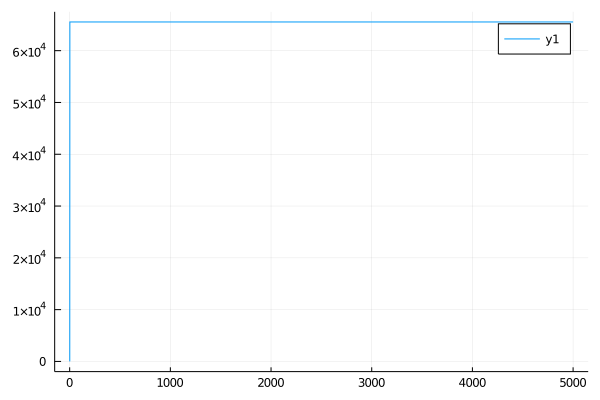

In [19]:
plot(masstab')